# cMLP Lagged VAR Demo

- In this notebook, we train a cMLP model on linear VAR data with lagged interactions.
- After examining the Granger causality discovery, we train a debiased model using only the discovered interactions.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_var
from models.cmlp import cMLP, cMLPSparse, train_model_ista, train_unregularized

max_iter_max = 40000
check_every = 10*np.floor(np.sqrt(max_iter_max))

In [2]:
# For GPU acceleration
device = torch.device('cpu')# torch.device('cuda')

In [3]:
# Simulate data
X_np, beta, GC = simulate_var(p=12, T=1078, lag=3)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

In [4]:
#print(beta)
#print(GC)
print(X.shape)
print(X.shape[-1])

torch.Size([1, 1078, 12])
12


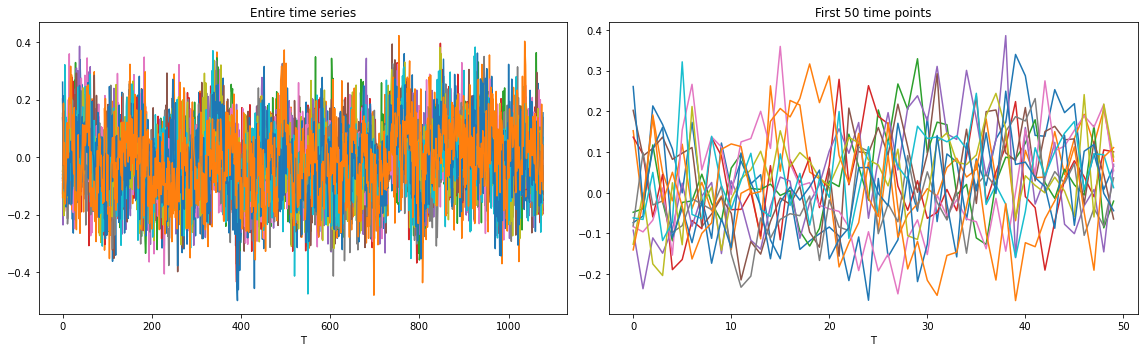

In [5]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

# Still need to tune $\lambda$ and perhaps lr

In [6]:
# Set up model
cmlp = cMLP(X.shape[-1], lag=5, hidden=[100])#.cuda(device=device)

In [7]:
# Train with ISTA
train_loss_list = train_model_ista(
    cmlp, X, lam=0.002, lam_ridge=1e-2, lr=5e-2, penalty='H', 
    max_iter=max_iter_max,
    check_every=check_every)

----------Iter = 2000----------
Loss = 0.080571
Variable usage = 100.00%
----------Iter = 4000----------
Loss = 0.035079
Variable usage = 100.00%
----------Iter = 6000----------
Loss = 0.021551
Variable usage = 100.00%
----------Iter = 8000----------
Loss = 0.017098
Variable usage = 100.00%
----------Iter = 10000----------
Loss = 0.015135
Variable usage = 37.50%
----------Iter = 12000----------
Loss = 0.015008
Variable usage = 24.31%
----------Iter = 14000----------
Loss = 0.014976
Variable usage = 20.83%
----------Iter = 16000----------
Loss = 0.014960
Variable usage = 19.44%
----------Iter = 18000----------
Loss = 0.014948
Variable usage = 18.75%
----------Iter = 20000----------
Loss = 0.014926
Variable usage = 18.06%
----------Iter = 22000----------
Loss = 0.014906
Variable usage = 16.67%
----------Iter = 24000----------
Loss = 0.014901
Variable usage = 16.67%
----------Iter = 26000----------
Loss = 0.014892
Variable usage = 15.97%
----------Iter = 28000----------
Loss = 0.014881
Va

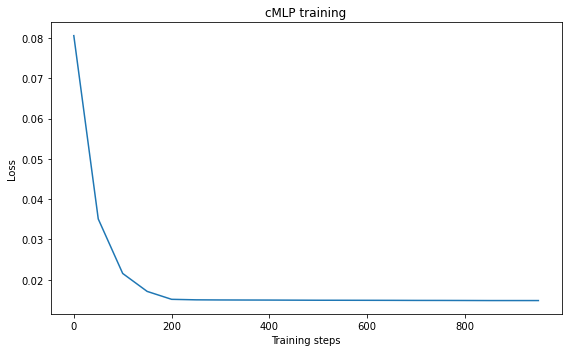

In [8]:
# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cMLP training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

True variable usage = 16.67%
Estimated variable usage = 13.89%
Accuracy = 94.44%


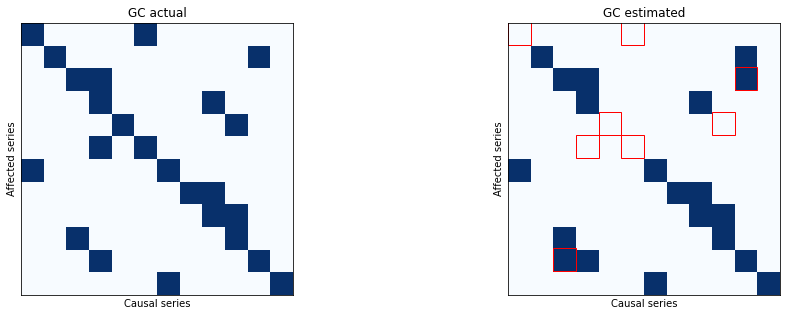

In [9]:
# Verify learned Granger causality
GC_est = cmlp.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_title('GC estimated')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()

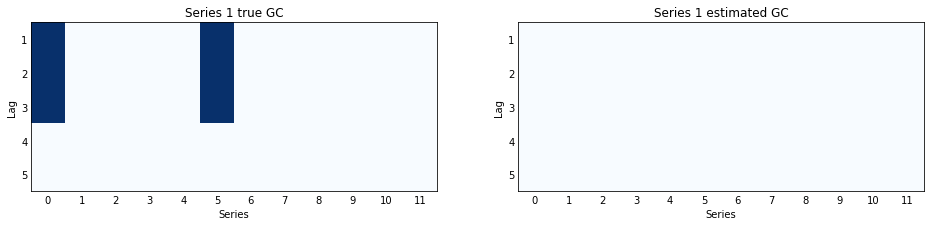

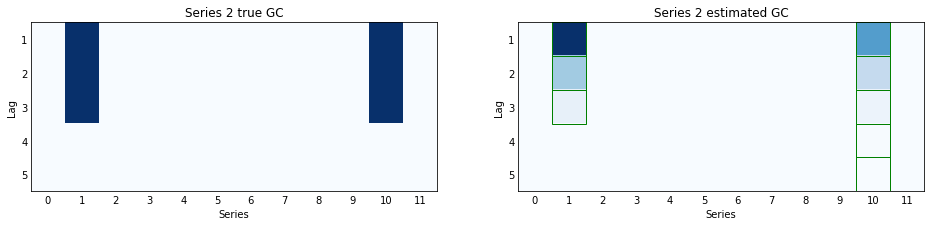

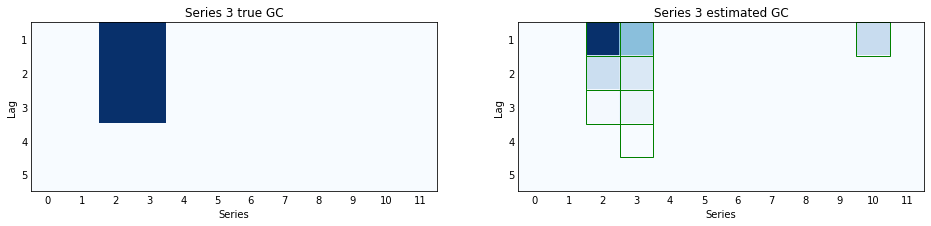

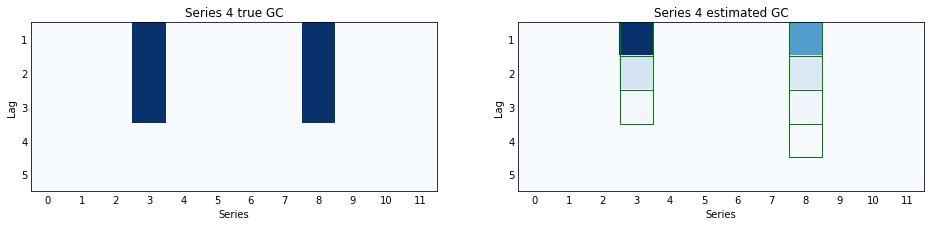

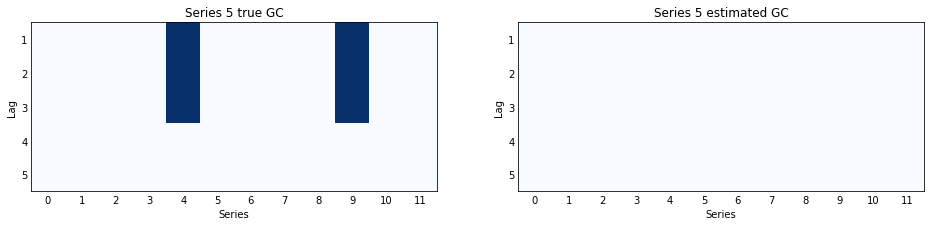

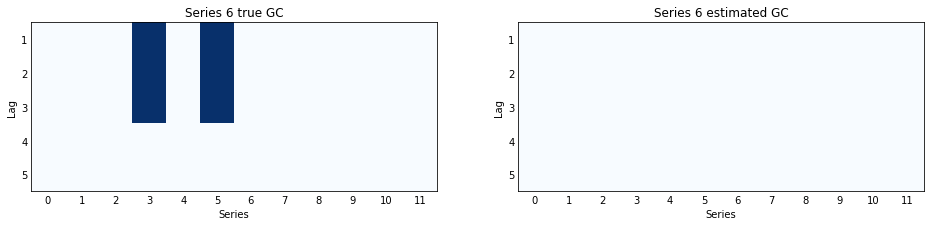

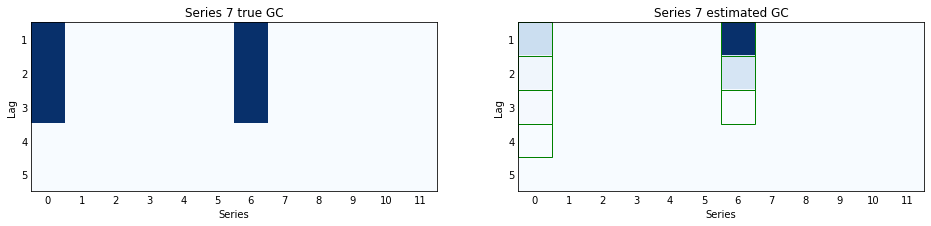

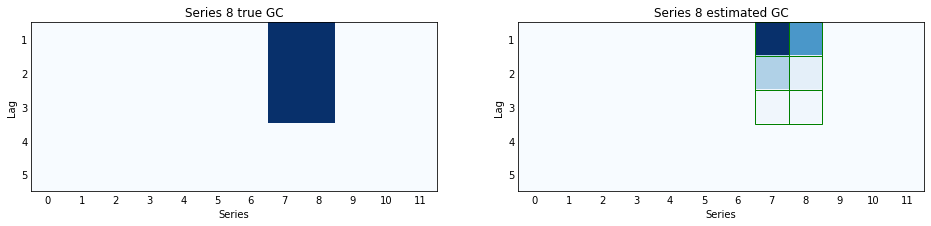

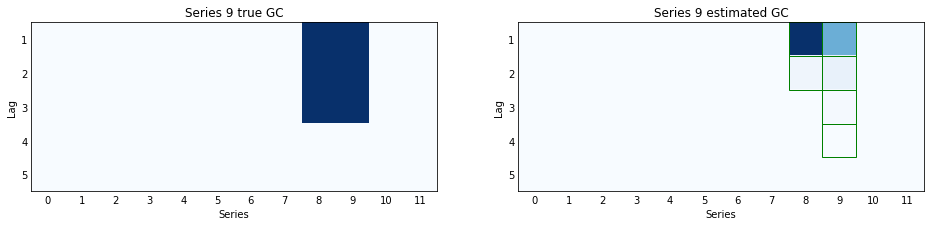

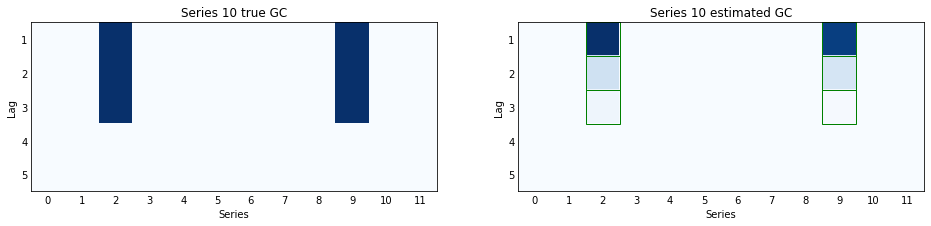

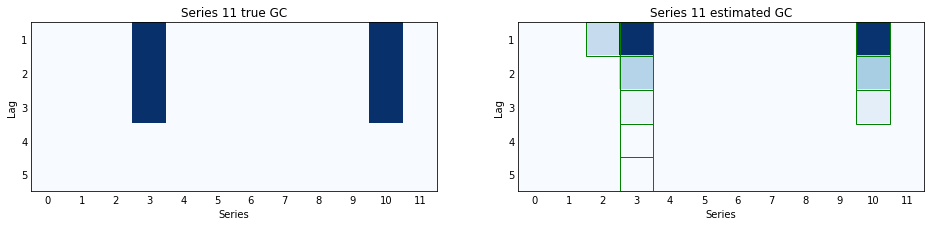

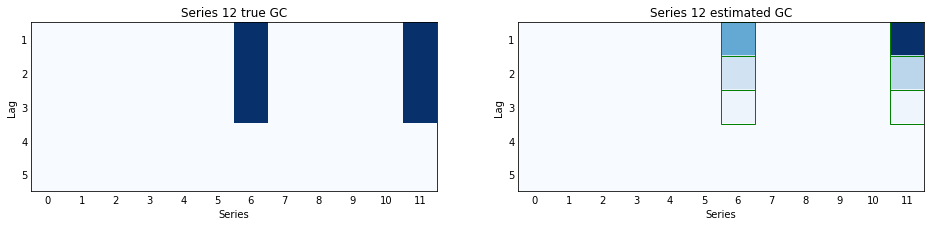

In [10]:
# Verify lag selection
for i in range(len(GC_est)):
    # Get true GC
    GC_lag = np.zeros((5, len(GC_est)))
    GC_lag[:3, GC[i].astype(bool)] = 1.0

    # Get estimated GC
    GC_est_lag = cmlp.GC(ignore_lag=False, threshold=False)[i].cpu().data.numpy().T[::-1]

    # Make figures
    fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
    axarr[0].imshow(GC_lag, cmap='Blues', extent=(0, len(GC_est), 5, 0))
    axarr[0].set_title('Series %d true GC' % (i + 1))
    axarr[0].set_ylabel('Lag')
    axarr[0].set_xlabel('Series')
    axarr[0].set_xticks(np.arange(len(GC_est)) + 0.5)
    axarr[0].set_xticklabels(range(len(GC_est)))
    axarr[0].set_yticks(np.arange(5) + 0.5)
    axarr[0].set_yticklabels(range(1, 5 + 1))
    axarr[0].tick_params(axis='both', length=0)

    axarr[1].imshow(GC_est_lag, cmap='Blues', extent=(0, len(GC_est), 5, 0))
    axarr[1].set_title('Series %d estimated GC' % (i + 1))
    axarr[1].set_ylabel('Lag')
    axarr[1].set_xlabel('Series')
    axarr[1].set_xticks(np.arange(len(GC_est)) + 0.5)
    axarr[1].set_xticklabels(range(len(GC_est)))
    axarr[1].set_yticks(np.arange(5) + 0.5)
    axarr[1].set_yticklabels(range(1, 5 + 1))
    axarr[1].tick_params(axis='both', length=0)

    # Mark nonzeros
    for i in range(len(GC_est)):
        for j in range(5):
            if GC_est_lag[j, i] > 0.0:
                rect = plt.Rectangle((i, j), 1, 1, facecolor='none', edgecolor='green', linewidth=1.0)
                axarr[1].add_patch(rect)

    plt.show()

# Train sparsified model

In [11]:
# Create a debiased model
sparsity = cmlp.GC().bool()
cmlp_sparse = cMLPSparse(X.shape[-1], sparsity, 
                         lag=5, hidden=[100])#.cuda(device=device)

# Train
train_loss_list = train_unregularized(cmlp_sparse, X, lr=1e-3, 
                                      max_iter=max_iter_max,
                                      check_every=check_every, 
                                      verbose=1)

/home/prasanna/.local/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: Given groups=1, weight of size [1, 100, 1], expected input[1, 0, 1073] to have 100 channels, but got 0 channels instead

In [ ]:
# Plot loss function
plt.figure(figsize=(10, 5))
plt.title('Debiased model training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.plot(100 * np.arange(len(train_loss_list)), train_loss_list)
plt.show()

In [ ]:
# Get optimal forecasts using VAR parameters
X_optimal_forecast = np.zeros((X.shape[-1], 1000-3))
for t in range(1000-3):
    X_optimal_forecast[:, t] = np.dot(beta, X_np.T[:, t:(t+3)].flatten(order='F'))
X_optimal_forecast = X_optimal_forecast.T

# Forecast using debiased cMLP
X_pred = cmlp_sparse(X)

# Plot actual data and forecasts
num_points = 25

for i in range(X.shape[-1]):
    plt.figure(figsize=(10, 5))
    plt.plot(X[0, 3:num_points+3, i].cpu().data.numpy(), label='Actual')
    plt.plot(X_pred[0, :num_points, i].cpu().data.numpy(), label='cMLP forecasting')
    plt.plot(X_optimal_forecast[:num_points, i], label='Optimal forecasting')
    plt.legend(loc='upper right')
    plt.title('Series %d forecasting' % (i + 1))
    plt.show()